# Data wrangling

### Summary

To ensure the dataset was clean and suitable for analysis, several preprocessing steps were taken:

#### anime_df
- Data type conversion: Converted features to their appropriate data types, such as converting object types to strings for names and categorical data for types.
- Handling missing values:
  - Ratings: Dropped rows without ratings, as they are the target variable and are essential for the analysis.
  - Genre: Filled missing genre values by referencing information from similar entries within the same series, identified through name similarities.
  - Number of episodes: For all types except TV and ONA, null episode values were replaced with the mean episode count, as these types typically have episode numbers within 4 standard deviations.
  - Remaining missing values: Dropped records with remaining missing values, which accounted for about 1% of the total dataset, to maintain data quality.
- Check for duplicates: Verified that there were no duplicate records in the dataset for unique name and type pairs.
- Check for outliers: The distributions of member count and episode count were left-skewed with a few large values. Spot checks confirmed the accuracy of these counts, as they correspond to popular and well-known anime titles.
- Genre splitting: Since the genre column contains arrays of values, each unique genre was split into its own column with boolean values indicating the presence or absence of that genre for each anime.


#### rating_df

- Check for missing values: Confirmed that there are no missing values in the dataset.
- Remove duplicates: Removed duplicate records based on the user_id and anime_id pair to ensure unique user-anime interactions.
- Check rating distributions: Observed that most ratings are 6 or above. Some records had a rating of -1, indicating that the user watched the anime but did not provide a rating. 


In [517]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import difflib

## Data Collection<a id='data_collection'></a>

In [518]:
anime_df = pd.read_csv('data/anime.csv')
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


- anime_id - myanimelist.net's unique id identifying an anime.
- name - full name of anime.
- genre - comma separated list of genres for this anime.
- type - movie, TV, OVA, etc.
- episodes - how many episodes in this show. (1 if movie).
- rating - average rating out of 10 for this anime.
- members - number of community members that are in this anime's "group".

In [519]:
rating_df = pd.read_csv('data/rating.csv')
rating_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


- user_id - non identifiable randomly generated user id.
- anime_id - the anime that this user has rated.
- rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).

## Data Cleaning<a id='data_cleaning'></a>

In [520]:
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [521]:
anime_df.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [522]:
(anime_df== 'Unknown').any()

anime_id    False
name        False
genre       False
type        False
episodes     True
rating      False
members     False
dtype: bool

In [523]:
# Replace string unknown with NaN type
anime_df.replace('Unknown', np.NaN, inplace=True)
(anime_df== 'Unknown').any()

anime_id    False
name        False
genre       False
type        False
episodes    False
rating      False
members     False
dtype: bool

### Drop rows with missing `rating` (which is our target)

In [524]:
anime_df = anime_df[~anime_df['rating'].isnull()]

In [525]:
anime_df.isna().sum()

anime_id      0
name          0
genre        47
type          0
episodes    188
rating        0
members       0
dtype: int64

### Fill missing value for `genre` [anime_df]

In [526]:
# Check if anime that has genre null is from the same anime but different episode title or type. 
# Check by finding if title has similarity to other animes. 
anime_has_null_genre = anime_df[anime_df['genre'].isnull()]
names_without_null_genre = anime_df[~anime_df['genre'].isnull()]['name']

anime_has_null_genre['matched_name'] = anime_has_null_genre['name'].apply(lambda x: difflib.get_close_matches(x, names_without_null_genre, n=1))
anime_has_null_genre.head()

/var/folders/xk/5gx1tq55563djqn2f91dfp040000gn/T/ipykernel_50884/1998551640.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_has_null_genre['matched_name'] = anime_has_null_genre['name'].apply(lambda x: difflib.get_close_matches(x, names_without_null_genre, n=1))


,anime_id,name,genre,type,episodes,rating,members,matched_name
2844,33242,IS: Infinite Stratos 2 - Infinite Wedding,NaN,Special,1,7.15,6604,[IS: Infinite Stratos 2]
3541,33589,ViVid Strike!,NaN,TV,12,6.96,12345,[]
6040,29765,Metropolis (2009),NaN,Movie,1,6.27,313,[Metropolis]
6646,32695,Match Shoujo,NaN,ONA,1,6.02,242,[Match Uri no Shoujo]
7018,33187,Katsudou Shashin,NaN,Movie,1,5.79,607,[Sakura Taisen: Katsudou Shashin]


In [527]:
anime_has_null_genre.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47 entries, 2844 to 10863
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   anime_id      47 non-null     int64  
 1   name          47 non-null     object 
 2   genre         0 non-null      object 
 3   type          47 non-null     object 
 4   episodes      46 non-null     object 
 5   rating        47 non-null     float64
 6   members       47 non-null     int64  
 7   matched_name  47 non-null     object 
dtypes: float64(1), int64(2), object(5)
memory usage: 3.3+ KB


In [528]:
# Fill the null genre with the matched anime's genre
df_has_null_genre = anime_has_null_genre.copy()
df_has_null_genre['matched_name'] = anime_has_null_genre['matched_name'].apply(lambda x: x[0] if len(x) > 0 else np.NaN)
df_has_null_genre['matched_genre'] = df_has_null_genre['matched_name'].apply(lambda x: anime_df[anime_df['name']==x]['genre'].values)
df_matched_genre = df_has_null_genre.copy()
df_matched_genre['matched_genre'] = df_has_null_genre['matched_genre'].apply(lambda x: x[0] if len(x) > 0 else np.NaN)
df_matched_genre.head()

,anime_id,name,genre,type,episodes,rating,members,matched_name,matched_genre
2844,33242,IS: Infinite Stratos 2 - Infinite Wedding,NaN,Special,1,7.15,6604,IS: Infinite Stratos 2,"Action, Comedy, Harem, Mecha, Sci-Fi"
3541,33589,ViVid Strike!,NaN,TV,12,6.96,12345,NaN,NaN
6040,29765,Metropolis (2009),NaN,Movie,1,6.27,313,Metropolis,"Adventure, Drama, Police, Romance, Sci-Fi, Sho..."
6646,32695,Match Shoujo,NaN,ONA,1,6.02,242,Match Uri no Shoujo,"Drama, Kids"
7018,33187,Katsudou Shashin,NaN,Movie,1,5.79,607,Sakura Taisen: Katsudou Shashin,"Adventure, Mecha, Sci-Fi, Shounen"


In [529]:
# Apply the filled data to anime_df
print('genre null count before: ', anime_df['genre'].isna().sum())
df_matched_genre[['anime_id', 'matched_genre']]
anime_df['genre'].fillna(df_matched_genre['matched_genre'], inplace=True)
print('genre null count after: ', anime_df['genre'].isna().sum())

genre null count before:  47
genre null count after:  10


/var/folders/xk/5gx1tq55563djqn2f91dfp040000gn/T/ipykernel_50884/2974107618.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  anime_df['genre'].fillna(df_matched_genre['matched_genre'], inplace=True)


In [530]:
anime_df.isna().sum()

anime_id      0
name          0
genre        10
type          0
episodes    188
rating        0
members       0
dtype: int64

### Fill missing value for `episodes` [anime_df]

In [531]:
# The hypothesis is that certain types will exhibit specific episode counts. For instance, movies typically have just one episode. 
# If we verify that there is a "typical" number of episodes associated with each type and this number shows little variation, 
# we will use it to impute missing episode values based on the type.
anime_df['episodes'] = pd.to_numeric(anime_df['episodes'], errors='coerce')

print('Missing episodes types:', anime_df[anime_df['episodes'].isna()]['type'].unique())
mean = anime_df[['type', 'episodes']].groupby('type').mean().rename(columns = {'episodes': 'mean'})
median = anime_df[['type', 'episodes']].groupby('type').median().rename(columns = {'episodes': 'median'})
std = anime_df[['type', 'episodes']].groupby('type').std().rename(columns = {'episodes': 'std'})
pd.concat((mean, median, std), axis=1)

Missing episodes types: ['TV' 'Special' 'ONA' 'Music' 'Movie' 'OVA']


,mean,median,std
type,,,
Movie,1.104530,1.0,2.171605
Music,1.131417,1.0,1.293852
ONA,6.862295,2.0,11.408264
OVA,2.422236,2.0,3.214364
Special,2.566026,1.0,3.704655
TV,35.969468,24.0,80.722257


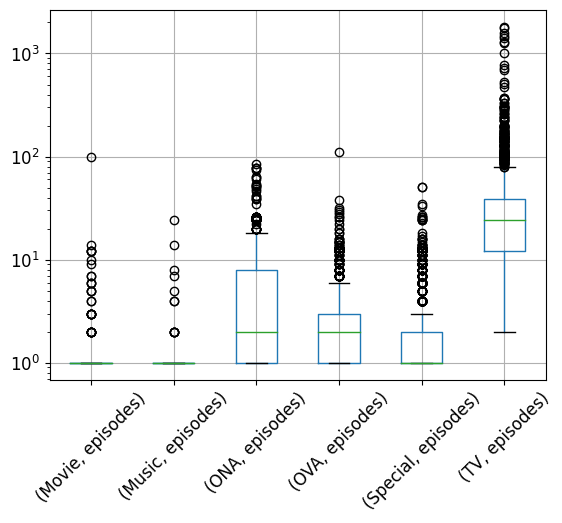

In [532]:
anime_df[['type', 'episodes']].groupby('type').boxplot(subplots=False, rot=45, fontsize=12)
plt.yscale('log')
plt.show()

All types except `TV` and `ONA` has less than 4 Standard Deviation for episode numbers. Will replace the null episode value with the rounded mean values for all types except `TV` and `ONA`.

In [533]:
avg_episodes_by_type = anime_df.groupby('type')['episodes'].mean()

In [534]:
anime_df.loc[(anime_df['type'] == 'Movie'), 'episodes'] = anime_df.loc[(anime_df['type'] == 'Movie'), 'episodes'].fillna(value=round(avg_episodes_by_type['Movie']))
anime_df.loc[(anime_df['type'] == 'Music'), 'episodes'] = anime_df.loc[(anime_df['type'] == 'Music'), 'episodes'].fillna(value=round(avg_episodes_by_type['Music']))
anime_df.loc[(anime_df['type'] == 'OVA'), 'episodes'] = anime_df.loc[(anime_df['type'] == 'OVA'), 'episodes'].fillna(value=round(avg_episodes_by_type['OVA']))
anime_df.loc[(anime_df['type'] == 'Special'), 'episodes'] = anime_df.loc[(anime_df['type'] == 'Special'), 'episodes'].fillna(value=round(avg_episodes_by_type['Special']))

In [535]:
anime_df.isna().sum()

anime_id      0
name          0
genre        10
type          0
episodes    143
rating        0
members       0
dtype: int64

**Decreased missing counts of episodes from 188 to 143.**

### Handle the rest of the missing values [anime_df]

In [536]:
anime_df[anime_df['episodes'].isna()].head()

,anime_id,name,genre,type,episodes,rating,members
74,21,One Piece,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",TV,NaN,8.58,504862
252,235,Detective Conan,"Adventure, Comedy, Mystery, Police, Shounen",TV,NaN,8.25,114702
615,1735,Naruto: Shippuuden,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,NaN,7.94,533578
991,966,Crayon Shin-chan,"Comedy, Ecchi, Kids, School, Shounen, Slice of...",TV,NaN,7.73,26267
1272,21639,Yu☆Gi☆Oh! Arc-V,"Action, Fantasy, Game, Shounen",TV,NaN,7.61,17571


It appears that when the episode count is missing for a TV anime, the series is still ongoing.

In [537]:
anime_df[anime_df['genre'].isna()].head()

,anime_id,name,genre,type,episodes,rating,members
3541,33589,ViVid Strike!,NaN,TV,12.0,6.96,12345
7198,30862,Yubi wo Nusunda Onna,NaN,Movie,1.0,5.65,223
7349,19219,Modern No.2,NaN,Movie,1.0,5.52,374
7685,31760,Tsuru Shitae Waka Kan,NaN,Movie,1.0,5.15,195
7824,28655,PiKA PiKA,NaN,Movie,1.0,4.92,289


In [538]:
(anime_df[(anime_df['genre'].isna()) | (anime_df['episodes'].isna())]['anime_id'].count())/ (anime_df['anime_id'].count())

0.01268236074270557

The rest of the missing value is about 1% of the total data. Will drop the records.

In [539]:
anime_df.dropna(inplace=True)
anime_df.isna().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

### Convert Data type [anime_df]

In [540]:
# Convert to expected datatype
anime_df['name'] = anime_df['name'].astype('string')
anime_df['type'] = anime_df['type'].astype('category')
anime_df['genre'] = anime_df['genre'].astype('string')
anime_df['episodes'] = anime_df['episodes'].astype('int')
print(anime_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 11911 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   anime_id  11911 non-null  int64   
 1   name      11911 non-null  string  
 2   genre     11911 non-null  string  
 3   type      11911 non-null  category
 4   episodes  11911 non-null  int64   
 5   rating    11911 non-null  float64 
 6   members   11911 non-null  int64   
dtypes: category(1), float64(1), int64(3), string(2)
memory usage: 663.2 KB
None


### Check duplicates [anime_df]

In [541]:
# Check duplicates
anime_df[['name', 'type']].duplicated().any()

False

### Check if any abnormal feature values [anime_df]

In [542]:
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11911 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   anime_id  11911 non-null  int64   
 1   name      11911 non-null  string  
 2   genre     11911 non-null  string  
 3   type      11911 non-null  category
 4   episodes  11911 non-null  int64   
 5   rating    11911 non-null  float64 
 6   members   11911 non-null  int64   
dtypes: category(1), float64(1), int64(3), string(2)
memory usage: 663.2 KB


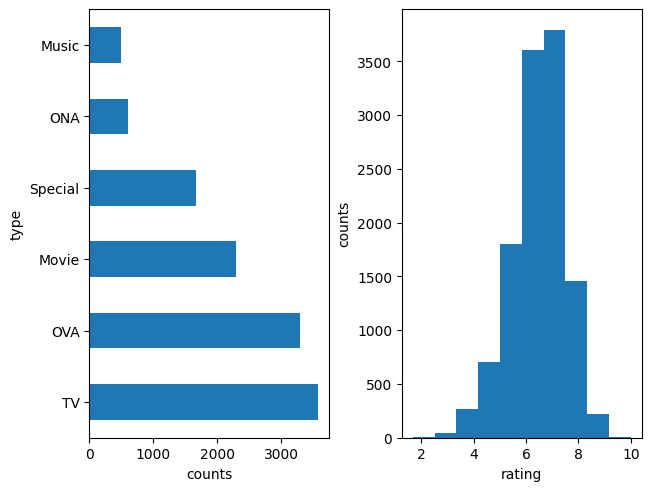

In [543]:
# Check feature outliers
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)
anime_df['type'].value_counts().plot(kind='barh', ax=ax1, xlabel='counts')
anime_df['rating'].plot(kind='hist', ax = ax2, bins=10, xlabel='rating', ylabel='counts')
plt.show()

Most of the anime are type OVA and TV. And most of the rating are between 5 to 7.

In [544]:
anime_df.describe()

,anime_id,episodes,rating,members
count,11911.000000,11911.000000,11911.000000,1.191100e+04
mean,13526.981026,12.416506,6.481722,1.839268e+04
std,11173.497214,46.945266,1.021110,5.520147e+04
min,1.000000,1.000000,1.670000,1.200000e+01
25%,3364.500000,1.000000,5.890000,2.295000e+02
50%,9895.000000,2.000000,6.570000,1.575000e+03
75%,23577.000000,12.000000,7.185000,9.694000e+03
max,34519.000000,1818.000000,10.000000,1.013917e+06


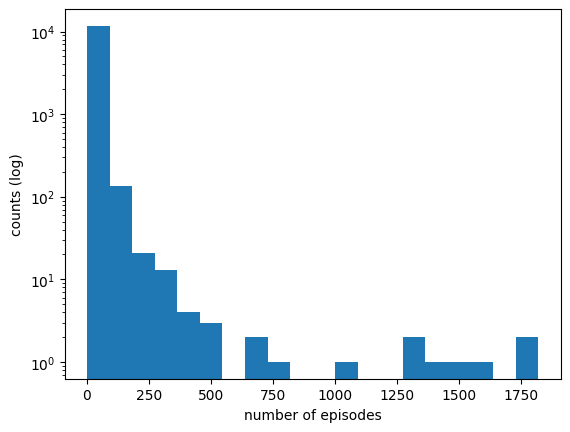

In [545]:
anime_df['episodes'].plot(kind='hist', bins=20, log= True, xlabel='number of episodes', ylabel='counts (log)')
plt.show()

Most of the anime are under 250 episodes. And we have some outliers that has 500 or more episodes.

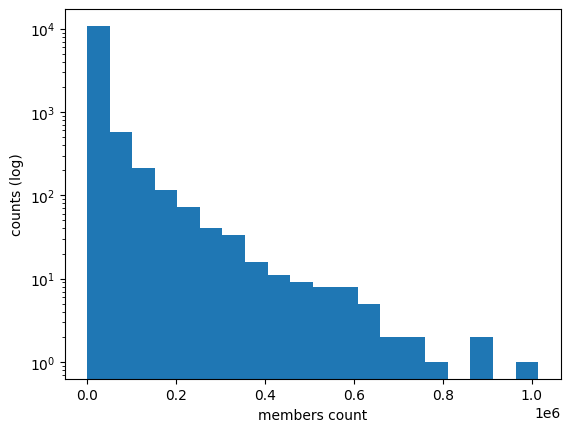

In [546]:
anime_df['members'].plot(kind='hist', bins=20, log=True, xlabel='members count', ylabel='counts (log)')
plt.show()

Most anime has lower number of member counts and the graph skew to the right.

In [547]:
anime_df[anime_df['episodes'] > 1000].head()

,anime_id,name,genre,type,episodes,rating,members
929,2471,Doraemon (1979),"Adventure, Comedy, Fantasy, Kids, Sci-Fi, Shounen",TV,1787,7.76,14233
5360,6277,Manga Nippon Mukashibanashi (1976),"Fantasy, Historical",TV,1471,6.48,406
6296,12393,Oyako Club,"Comedy, Slice of Life",TV,1818,6.18,160
6580,8213,Hoka Hoka Kazoku,Comedy,TV,1428,6.05,194
9242,32448,Kirin Ashita no Calendar,"Historical, Kids",TV,1306,6.43,59


Upon spot-checking anime with over 1,000 episodes, the episode counts appear to be accurate.

In [548]:
anime_df[anime_df['members'] > 100000].head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


Upon spot-checking anime with over 100,000 members, the number appear to be accurate as well since those are very popular and well know anime.

### Split each genre into columns [anime_df]

Since the genre column contains arrays of values, each unique genre was split into its own column with boolean values indicating the presence or absence of that genre for each anime.

In [549]:
genre_columns = anime_df['genre'].str.get_dummies(sep=', ')
anime_df = pd.concat([anime_df, genre_columns], axis=1)
anime_df = anime_df.drop('genre', axis=1)
anime_df

,anime_id,name,type,episodes,rating,members,Action,Adventure,Cars,Comedy,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,32281,Kimi no Na wa.,Movie,1,9.37,200630,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,5114,Fullmetal Alchemist: Brotherhood,TV,64,9.26,793665,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,28977,Gintama°,TV,51,9.25,114262,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,9253,Steins;Gate,TV,24,9.17,673572,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,9969,Gintama&#039;,TV,51,9.16,151266,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,OVA,1,4.15,211,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12290,5543,Under World,OVA,1,4.28,183,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12291,5621,Violence Gekiga David no Hoshi,OVA,4,4.88,219,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,OVA,1,4.98,175,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Quick look at rating_df

### Check missing value [rating_df]

In [550]:
#Cleaning for rating
print(rating_df.info())
rating_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB
None


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [551]:
rating_df.isna().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

### Drop duplicates

In [552]:
rating_df[rating_df.duplicated(keep=False)]

,user_id,anime_id,rating
4499258,42653,16498,8
4499316,42653,16498,8


### Check feature value distributions [rating_df]¶

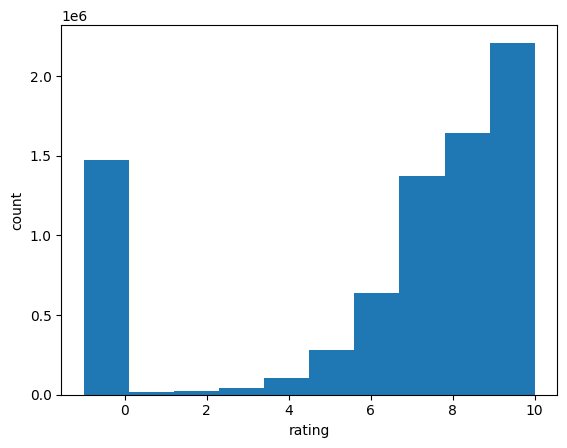

In [553]:
rating_df['rating'].plot(kind='hist', xlabel='rating', ylabel='count')
plt.show()

A lot of the ratings are in the range of 6 or above. We also see some record as -1 as rating value. This means the user watched the anime but didn't provide a rating.

In [554]:
rating_df['rating'].unique()

array([-1, 10,  8,  6,  9,  7,  3,  5,  4,  1,  2])

## Add features to anime_df

Adding the follwing features to the anime_df for the next phase of the analysis:
- number of reviews
- number of views without reviews

In [555]:
view_count_per_anime = rating_df[rating_df.rating == -1].groupby('anime_id')['user_id'].count()
view_count_per_anime = view_count_per_anime.rename('views_without_review')
view_count_per_anime.head()

anime_id
1    2060
5    1137
6    1692
7     460
8     105
Name: views_without_review, dtype: int64

In [556]:
rating_count_per_anime = rating_df[rating_df.rating >=0].groupby('anime_id')['user_id'].count()
rating_count_per_anime = review_count_per_anime.rename('rating_counts')
rating_count_per_anime.head()

anime_id
1    13449
5     5790
6     9385
7     2169
8      308
Name: rating_counts, dtype: int64

In [557]:
anime_df = anime_df.join(view_count_per_anime, on='anime_id', how='left')
anime_df = anime_df.join(rating_count_per_anime, on='anime_id', how='left')
anime_df.head()

,anime_id,name,type,episodes,rating,members,Action,Adventure,Cars,Comedy,...,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri,views_without_review,rating_counts
0,32281,Kimi no Na wa.,Movie,1,9.37,200630,0,0,0,0,...,0,0,0,1,0,0,0,0,238.0,1961.0
1,5114,Fullmetal Alchemist: Brotherhood,TV,64,9.26,793665,1,1,0,0,...,0,0,0,0,0,0,0,0,3080.0,21494.0
2,28977,Gintama°,TV,51,9.25,114262,1,0,0,1,...,0,0,0,0,0,0,0,0,198.0,1188.0
3,9253,Steins;Gate,TV,24,9.17,673572,0,0,0,0,...,0,0,0,0,1,0,0,0,2132.0,17151.0
4,9969,Gintama&#039;,TV,51,9.16,151266,1,0,0,1,...,0,0,0,0,0,0,0,0,558.0,3115.0


In [558]:
anime_df.loc[:, 'views_without_review'] = anime_df.loc[:, 'views_without_review'].fillna(value=0)

In [559]:
mean_rating_count_per_rating = anime_df.groupby(anime_df['rating'].apply(lambda x: round(x)))['rating_counts'].mean()
mean_rating_count_per_rating

rating
2      327.750000
3       11.282609
4       15.436823
5       25.164444
6       90.466711
7      504.675872
8     2288.455345
9     6089.489362
10            NaN
Name: rating_counts, dtype: float64

In [560]:
for i in range(2,10):
    anime_df.loc[round(anime_df.rating) == i, 'rating_counts'] = anime_df.loc[round(anime_df.rating) == i, 'rating_counts'].fillna(value=round(mean_rating_count_per_rating[i]))

anime_df.loc[round(anime_df.rating) == 10, 'rating_counts'] = anime_df.loc[round(anime_df.rating) == 10, 'rating_counts'].fillna(value=1)


In [562]:
anime_df['views_without_review'] = anime_df['views_without_review'].astype('int')
anime_df['rating_counts'] = anime_df['rating_counts'].astype('int')

print(anime_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 11911 entries, 0 to 12293
Data columns (total 51 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   anime_id              11911 non-null  int64   
 1   name                  11911 non-null  string  
 2   type                  11911 non-null  category
 3   episodes              11911 non-null  int64   
 4   rating                11911 non-null  float64 
 5   members               11911 non-null  int64   
 6   Action                11911 non-null  int64   
 7   Adventure             11911 non-null  int64   
 8   Cars                  11911 non-null  int64   
 9   Comedy                11911 non-null  int64   
 10  Dementia              11911 non-null  int64   
 11  Demons                11911 non-null  int64   
 12  Drama                 11911 non-null  int64   
 13  Ecchi                 11911 non-null  int64   
 14  Fantasy               11911 non-null  int64   
 15  Game   

## Data Definition<a id='data_definition'></a>

In [563]:
# save data
anime_df.to_csv('data/anime_df.csv', sep=',')
rating_df.to_csv('data/rating_df.csv', sep=',')
